In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import ensemble, svm
from sklearn import metrics

from pandas.api.types import is_string_dtype

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'

In [41]:
# path = 'melbourne-housing-market/'
file = 'breast-cancer-wisconsin.csv'

col_names = ['code', 'clump_thickness', 'cell_size_uniformity', 'cell_shape_uniformity', 
         'marginal_adhesion', 'cell_size_single_epithelial','bare_nuclei', 'bland_chromatin', 
        'normal_nucleoli', 'mitoses', 'class']

df_all = pd.read_csv(file)
# df_all.columns = col_names


In [70]:
# Check which columns have missing values and how many
df_all.isna().sum()

code                            0
clump_thickness                 0
cell_size_uniformity            0
 cell_shape_uniformity          0
 marginal_adhesion              0
 cell_size_single_epithelial    0
bare_nuclei                     0
 bland_chromatin                0
 normal_nucleoli                0
 mitoses                        0
diag                            0
dtype: int64

In [63]:
df_all.bare_nuclei.replace('?', np.nan)
df_all.diag = df_all.diag.replace({4:'M', 2:'B'})
df_all = df_all.dropna()

In [64]:
for col in df_all.columns:
    try:
        df_all[col] = pd.to_numeric(df_all[col])
    except:
        print(col, len(set(df_all[col])))

diag 2


In [59]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
code                            683 non-null int64
clump_thickness                 683 non-null int64
cell_size_uniformity            683 non-null int64
 cell_shape_uniformity          683 non-null int64
 marginal_adhesion              683 non-null int64
 cell_size_single_epithelial    683 non-null int64
bare_nuclei                     683 non-null int64
 bland_chromatin                683 non-null int64
 normal_nucleoli                683 non-null int64
 mitoses                        683 non-null int64
diag                            683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


In [65]:
print('percent malignent:',len(df_all[df_all.diag=='M'])/len(df_all)*100)
print('percent benign:',len(df_all[df_all.diag=='B'])/len(df_all)*100)
print('suggests minimal class imablance!')

percent malignent: 34.99267935578331
percent benign: 65.00732064421669
suggests minimal class imablance!


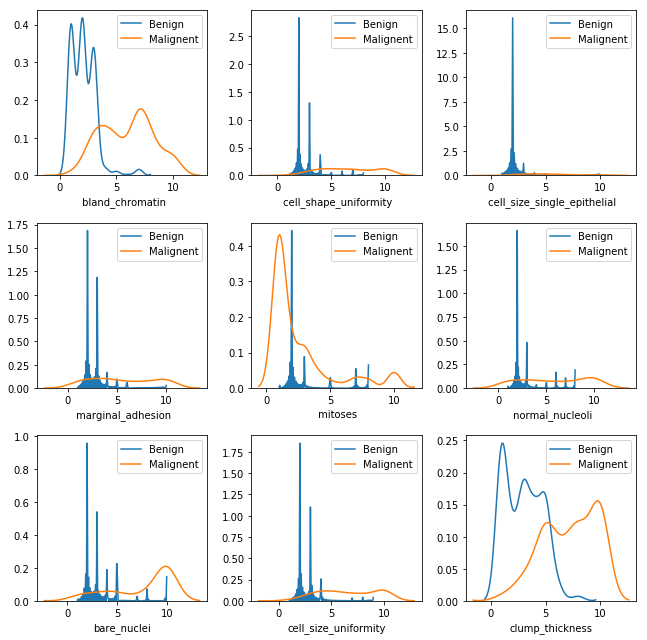

In [69]:

%config InlineBackend.figure_format = 'png'
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for ik, feat in enumerate(df_all.columns.difference(['diag', 'code'])):
    ax = axes[int(ik / 3), ik%3]
    sns.kdeplot(df_all[df_all.diag=='B'][feat], ax=ax, label = 'Benign')
    sns.kdeplot(df_all[df_all.diag=='M'][feat], ax=ax, label= 'Malignent')
    ax.set_xlabel(feat)
    
fig.tight_layout();



In [73]:
target = 'diag'

X = df_all.loc[:, ~(df_all.columns).isin([target])]
y = df_all[target]

In [74]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [86]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=300)
gbc.fit(X_train, y_train)
gbc_score = gbc.score(X_test, y_test)
print('score:', gbc_score)
cv_scores = cross_val_score(gbc,X_train,y_train, cv = 5)
print('cross validations scores:', cv_scores)
preds = gbc.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, preds)
print(conf_matrix)
print(metrics.classification_report(y_test, preds))

score: 0.964912280702
cross validations scores: [ 0.98058252  0.96116505  0.96116505  0.97058824  0.96039604]
[[101   0]
 [  6  64]]
              precision    recall  f1-score   support

           B       0.94      1.00      0.97       101
           M       1.00      0.91      0.96        70

   micro avg       0.96      0.96      0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



In [85]:
#Standardize the data before feeding it to PCA algorithm
sclr = StandardScaler()
sclr.fit(X_train[X_train.columns])

X_train_scaled = pd.DataFrame(sclr.transform(X_train[X_train.columns]), columns = X_train.columns)
X_test_scaled = pd.DataFrame(sclr.transform(X_test[X_test.columns]), columns = X_test.columns)
y_train_scaled = y_train
y_test_scaled = y_test

svc = svm.SVC()
svc.fit(X_train_scaled, y_train_scaled)
svc_score = svc.score(X_test_scaled, y_test_scaled)
print('score:', svc_score)
cv_scores = cross_val_score(svc, X_train_scaled,y_train_scaled, cv = 5)
print('cross validations scores:', cv_scores)
preds = svc.predict(X_test_scaled)

conf_matrix = metrics.confusion_matrix(y_test_scaled, preds)
print(conf_matrix)
print(metrics.classification_report(y_test_scaled, preds))

score: 0.976608187135
cross validations scores: [ 0.98058252  0.94174757  0.95145631  0.96078431  0.95049505]
[[100   1]
 [  3  67]]
              precision    recall  f1-score   support

           B       0.97      0.99      0.98       101
           M       0.99      0.96      0.97        70

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171



In [88]:
## Probing for important features

for feat in df_all.columns:
    X = df_all.loc[:, ~(df_all.columns).isin([target]+[feat]+ ['code'])]
    y = df_all[target]
    
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    
    gbc = ensemble.GradientBoostingClassifier(n_estimators=300)
    gbc.fit(X_train, y_train)
    gbc_score = gbc.score(X_test, y_test)
    print(feat)
    print('score:', gbc_score)
    cv_scores = cross_val_score(gbc,X_train,y_train, cv = 5)
    print('cross validations scores:', cv_scores)
    print('')
    

code
score: 0.964912280702
cross validations scores: [ 0.97115385  0.98039216  0.94117647  0.97058824  0.98039216]

clump_thickness
score: 0.982456140351
cross validations scores: [ 0.9223301   0.97087379  0.95098039  0.94117647  0.99019608]

cell_size_uniformity
score: 0.964912280702
cross validations scores: [ 0.96116505  0.95145631  0.98058252  0.97058824  0.98019802]

 cell_shape_uniformity
score: 0.953216374269
cross validations scores: [ 0.95145631  0.98058252  0.98039216  0.97058824  0.99019608]

 marginal_adhesion
score: 0.93567251462
cross validations scores: [ 0.97087379  0.98058252  0.95145631  0.97058824  0.99009901]

 cell_size_single_epithelial
score: 0.959064327485
cross validations scores: [ 0.96116505  0.95145631  0.98058252  0.98039216  0.94059406]

bare_nuclei
score: 0.947368421053
cross validations scores: [ 0.93203883  0.98058252  0.97058824  0.98039216  0.94117647]

 bland_chromatin
score: 0.959064327485
cross validations scores: [ 0.97087379  0.97087379  0.970873

Removing each variable one at a time, we can see that clump_thickness followed by marginal_adhesion have the most influence on model results.  